# Solving Simflied Thick Ptychography Model Least Squares Problem

This tutorial demonstrates how to use `thickptypy` to set up and solve a least_squares problem to reconstuct a thick sample.

The wave inversion is posed as a least-squares problem:

\begin{equation}
E(n) = \frac{1}{2} \sum_{i=1}^{N} \| p_i(n) - p_{\text{obs},i} \|^2_2,
\end{equation}

where $p_i$ and $p_{\text{obs},i}$ are the simulated and observed exit waves for the $i$-th probe position in Ptychography. 

$n(x,z)$ defines the refractive index of the volume

### 1. Import Libraries: Sample Space, Least Squares Solver and Visualisation

In [1]:
from thickptypy.sample_space.sample_space import SampleSpace
from thickptypy.reconstruction.least_squares import LeastSquaresSolver
from thickptypy.utils.visualisations import Visualisation

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [2]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "disk"                 # Disk probe
wave_number = 5e-1                   # Wavenumber (micrometers^-1)

# Continuous space limits (micrometers)
xlims = [0,1500]                    # X limits in micrometers
zlims = [0,5000]                   # Z limits in micrometers
continuous_dimensions = [
    xlims,
    zlims
    ]                     # Continuous dimensions in micrometers

# Discrete space parameters
propagation_slices = 50             # Number of z slices
probe_dimensions = [15]             # Discrete Probe dimensions
scan_points = 100                   # Large number of probes needed
step_size = 1                       # Step size in pixels


# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
print(f"Pixels for compatibility with Diamond thin-sample simulation:")
print(f"nx = {min_nx}")
print(f"(These are also the minimum values for the discrete space limits)")

# Number of pixels in x directions
nx= 130
if nx < min_nx:
    nx = min_nx
discrete_dimensions = [
    nx,
    propagation_slices
    ]   

Pixels for compatibility with Diamond thin-sample simulation:
nx = 115
(These are also the minimum values for the discrete space limits)


### 3. Create Sample Space, Add Objects and Visualise it.

Add rectangles with specified refractive indices to the sample space.

In [3]:
sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    wave_number,            # wavenumber in 1/nm
)
sample_space.summarize_sample_space()
visualisation = Visualisation(sample_space)

Summary of the scan (continuous):
    Sample space x: 1500 um
    Sample space z: 5000 um
    Probe Diameter: 174.42 um
    Number of scan points: 100
    Max Overlap: 162.88 um 



In [4]:
delta = 1e-4
beta = 1e-6j
refractive_index1 = - delta + beta
refractive_index2 = - 0.9 * delta + 1.1*beta
guassian_blur = 0.6

sample_space.add_object('circle', refractive_index1, side_length=75, centre=(xlims[1]*0.9,zlims[1]*0.8),depth=600,guassian_blur=guassian_blur)
sample_space.add_object('circle', refractive_index1, side_length=75, centre=(xlims[1]*0.5,zlims[1]*0.5),depth=600,guassian_blur=guassian_blur)
sample_space.add_object('circle', refractive_index1, side_length=75, centre=(xlims[1]*0.25,zlims[1]*0.25),depth=600,guassian_blur=guassian_blur)
sample_space.add_object('circle', refractive_index2, side_length=150, centre=(xlims[1]*0.7,zlims[1]*0.2),depth=1200,guassian_blur=guassian_blur)
sample_space.add_object('circle', refractive_index2, side_length=150, centre=(xlims[1]*0.1,zlims[1]*0.8),depth=1200,guassian_blur=guassian_blur)
sample_space.generate_sample_space()

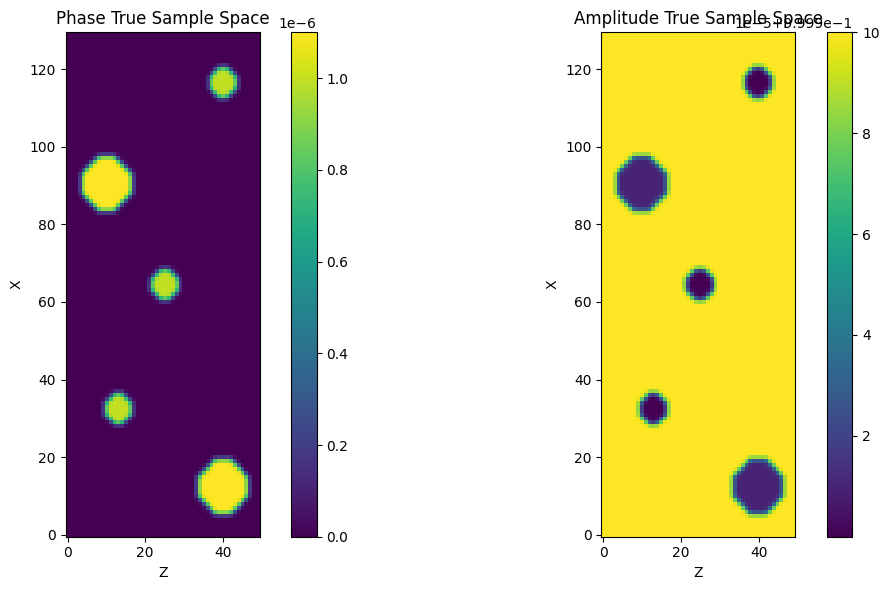

In [5]:
# Plot the true sample space
title = "True Sample Space"
visualisation.plot(sample_space.n_true, title=title)

### 6. Solve Least Squares to Reconstruct Simulated Sample Space


In [6]:
# Solve full system all-at-once or iteratively
least_squares = LeastSquaresSolver(sample_space,full_system_solver=True)

Initializing Least Squares Solver...
Solving the true forward problem once to generate the dataset...
True Forward Solution computed in 0.12 seconds.


/home/dnz75396/thickptypy/thickptypy/forward_model/solver.py:64: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = spla.splu(self.return_forward_model_matrix(n=n))


True Object


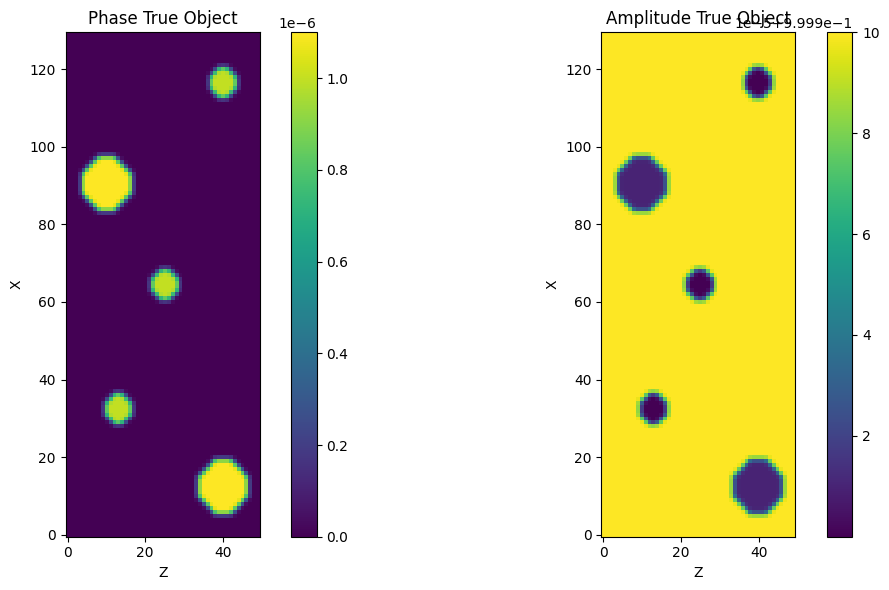

/home/dnz75396/thickptypy/thickptypy/reconstruction/least_squares.py:62: SparseEfficiencyWarning: splu converted its input to CSC format
  self.lu = spla.splu(self.Ak)


Iteration 1/10
    RMSE: 2.2169037162927518e-05
    Reconstructed Object


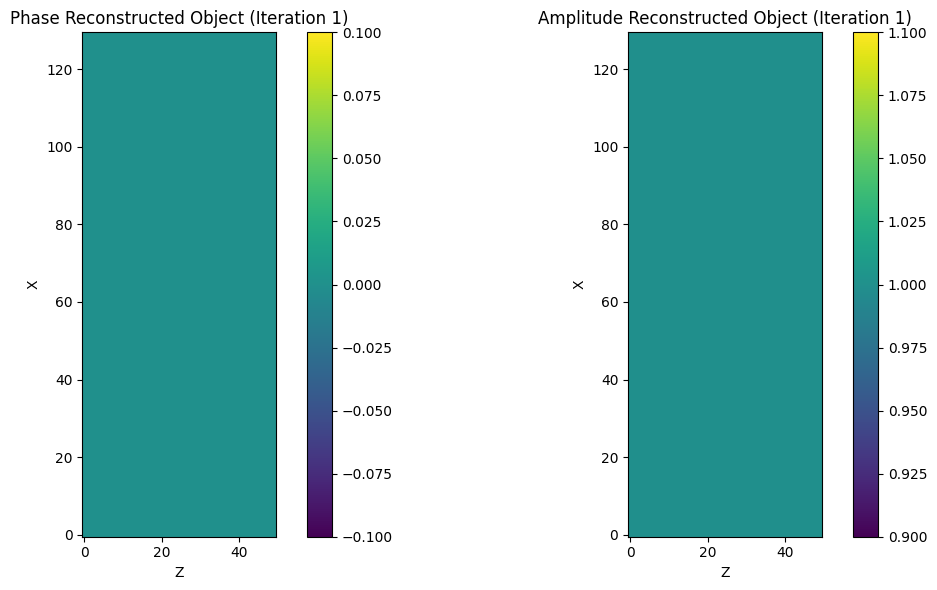

    Iteration 1 took 0.51 seconds.
Iteration 2/10
    RMSE: 2.1782310958560722e-05
    Iteration 2 took 0.36 seconds.
Iteration 3/10
    RMSE: 2.146288672505008e-05
    Iteration 3 took 0.33 seconds.
Iteration 4/10
    RMSE: 2.1188065232102785e-05
    Iteration 4 took 0.34 seconds.
Iteration 5/10
    RMSE: 2.095578967774989e-05
    Reconstructed Object


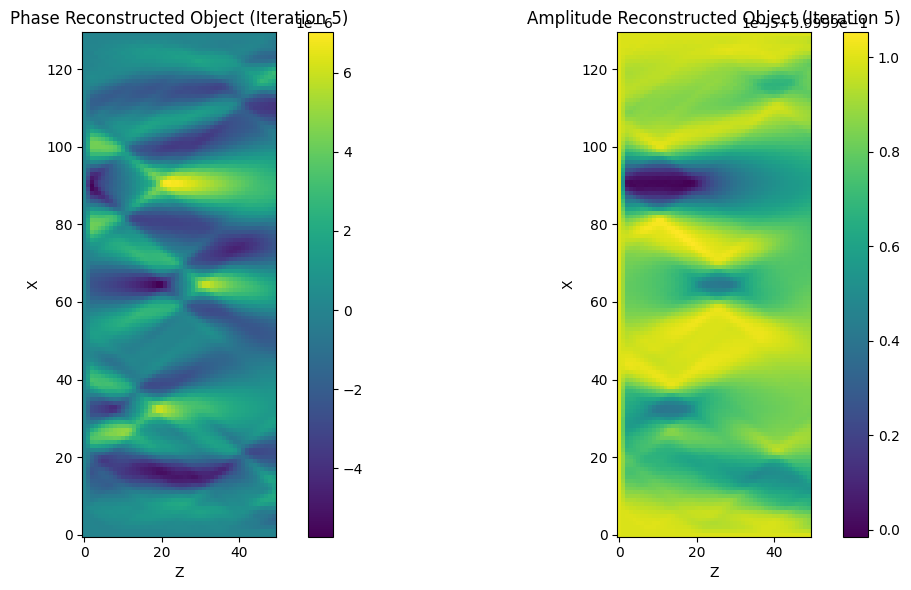

    Iteration 5 took 0.57 seconds.
Iteration 6/10
    RMSE: 2.076799419995883e-05
    Iteration 6 took 0.34 seconds.
Iteration 7/10
    RMSE: 2.062303053034272e-05
    Iteration 7 took 0.34 seconds.
Iteration 8/10
    RMSE: 2.0491574039057842e-05
    Iteration 8 took 0.34 seconds.
Iteration 9/10
    RMSE: 2.0342740561284933e-05
    Iteration 9 took 0.34 seconds.
Iteration 10/10
    RMSE: 2.0186336205585917e-05
    Reconstructed Object


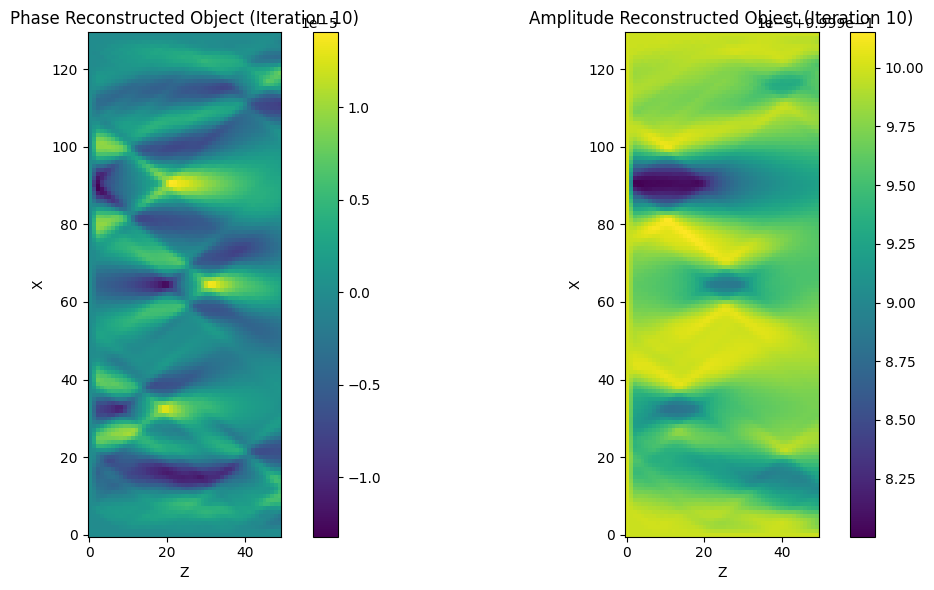

    Iteration 10 took 0.50 seconds.


In [7]:
max_iters = 10
reconstructed_sample_space, reconstructed_wave, residual_history = (
    least_squares.solve(max_iters=max_iters,
                        plot_forward=False,
                        plot_object=True,
                        fixed_step_size=None,
                        sparsity_lambda=0.05,
                        l2_lambda=0.15)
)

# %load_ext line_profiler
# target_method = least_squares.forward_model.linear_system.probe_contribution
# %lprun -f target_method least_squares.solve(max_iters=max_iters, plot_forward=False, plot_object=True, fixed_step_size=None, sparsity_lambda=0.05, l2_lambda=0.15)
# #%lprun -f LeastSquaresSolver.forward_model.solve least_squares.solve(max_iters=max_iters, plot_forward=False, plot_object=True, fixed_step_size=None, sparsity_lambda=0.05, l2_lambda=0.15)


### 7. Visualise the Residual History and Final Iterations

Residual History of Least Squares Solve


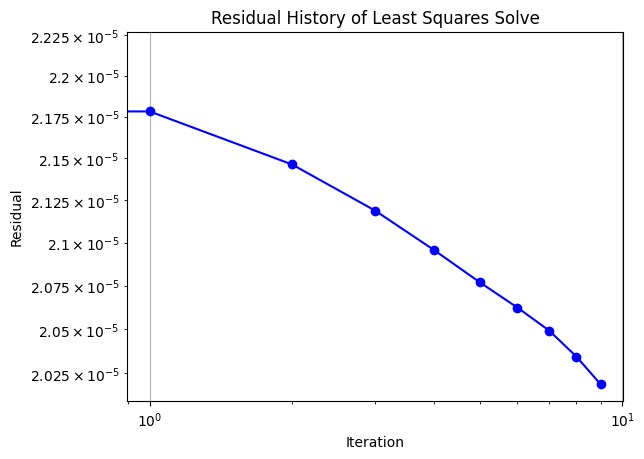

In [8]:
import matplotlib.pyplot as plt

# Log-log plot of residual
title ='Residual History of Least Squares Solve'
print(title)
plt.figure()
plt.loglog(residual_history, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title(title)
plt.grid(True)
plt.show()

Reconstructed Sample Space


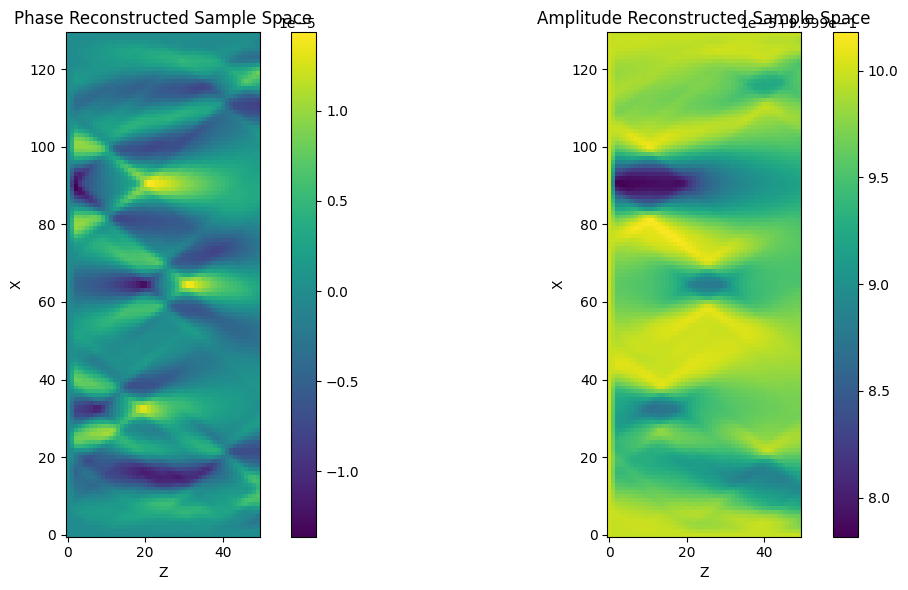

True Sample Space


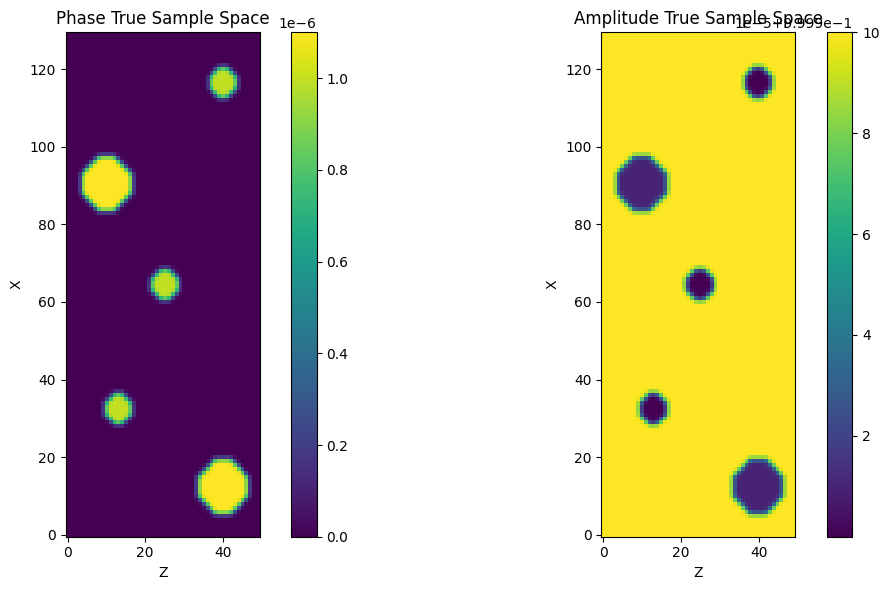

In [9]:
# Plot object field
title = "Reconstructed Sample Space"
print(title)
visualisation.plot(reconstructed_sample_space,title=title)

# Plot the true sample space
title = "True Sample Space"
print(title)
visualisation.plot(sample_space.n_true, title=title)

Reconstructed Wave


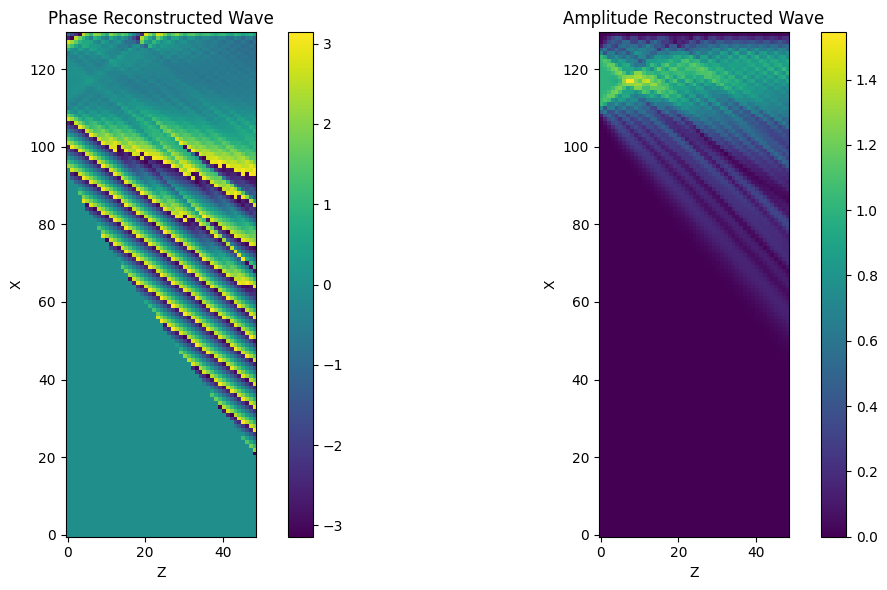

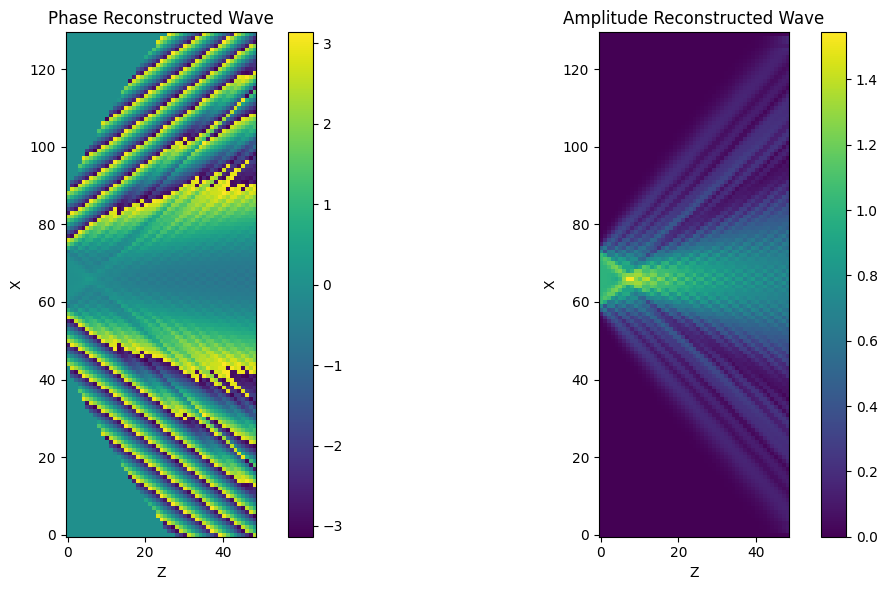

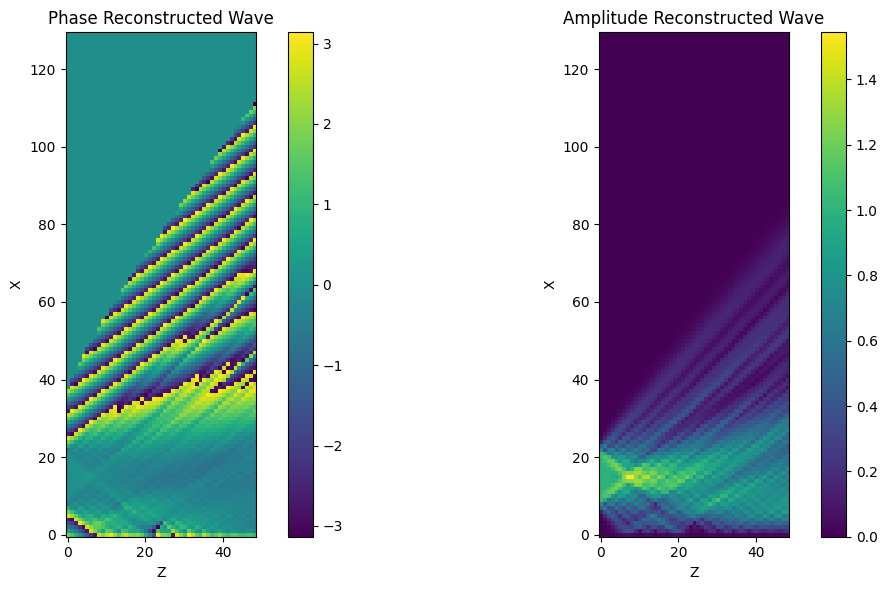

In [10]:
# Plot the reconstructed wave
title = "Reconstructed Wave"
print(title)
visualisation.plot(reconstructed_wave, title=title, probe_index=-1)
visualisation.plot(reconstructed_wave, title=title)
visualisation.plot(reconstructed_wave, title=title, probe_index=0)

In [11]:
# Profile the reconstruction
# %load_ext line_profiler
# %lprun -f SolveLeastSquares.compute_forward_model least_squares.solve(max_iters=max_iters, plot_forward=True, plot_object=True, fixed_step_size=False)